Using device: cpu
Epoch 1/5, Train Loss: 0.7327, Val Loss: 0.6923, Val Accuracy: 52.00%
Epoch 2/5, Train Loss: 0.6932, Val Loss: 0.6923, Val Accuracy: 52.00%
Epoch 3/5, Train Loss: 0.6906, Val Loss: 0.6910, Val Accuracy: 52.50%
Epoch 4/5, Train Loss: 0.6735, Val Loss: 0.6876, Val Accuracy: 55.00%
Epoch 5/5, Train Loss: 0.5796, Val Loss: 0.7146, Val Accuracy: 48.50%


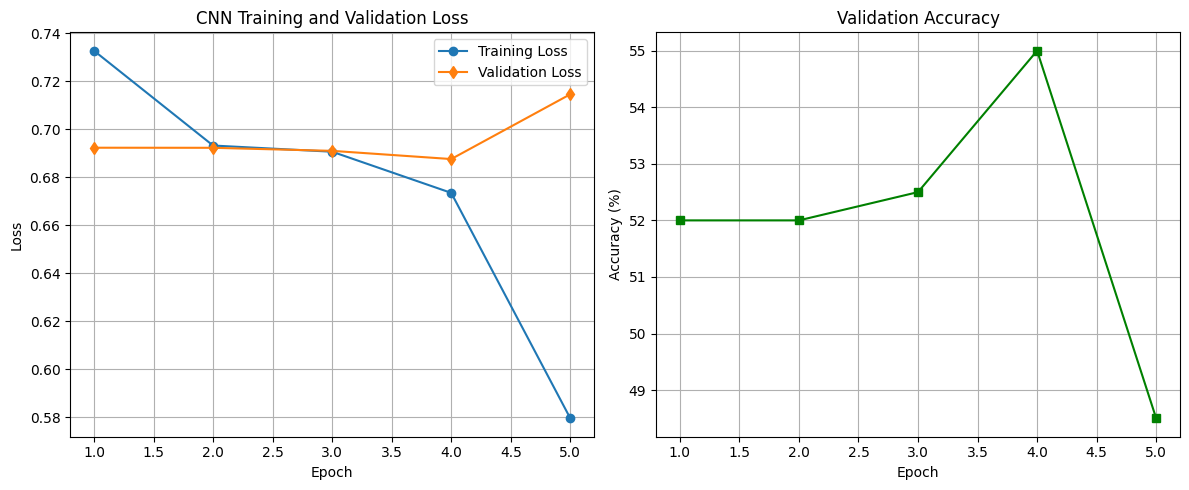

Prediction for test image: Undamaged


In [ ]:
#CNN for Product Damage Detection (PyTorch + Training-Loss Plot)

#Scenario: Use images to detect damaged products vs. undamaged products in a manufacturing or fulfillment center context.

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Create synthetic dataset for binary classification (simulating damaged/undamaged)
def create_synthetic_data(num_samples=1000, input_size=64):
    # Create feature tensors (simulating images)
    X = torch.randn(num_samples, 3, input_size, input_size)
    
    # Create labels: 0 for undamaged, 1 for damaged
    y = torch.randint(0, 2, (num_samples,))
    
    return X, y

# Generate data
train_X, train_y = create_synthetic_data(1000)
val_X, val_y = create_synthetic_data(200)

# Create datasets and loaders
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# CNN Model Definition
class DamageClassifier(nn.Module):
    def __init__(self):
        super(DamageClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        # Calculate output size after convolutions and pooling
        # With padding=1, size is maintained after conv layers
        # After two 2x2 max pooling: 64 -> 32 -> 16
        feature_size = 16  # After 2 pooling layers on 64x64 input
        self.fc1 = nn.Linear(32 * feature_size * feature_size, 128)
        self.fc2 = nn.Linear(128, 2)  # Binary classification
        
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        
        # Print shape for debugging - uncomment if needed
        # print(f"Shape before flattening: {x.shape}")
        
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = DamageClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
train_loss_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    train_loss_history.append(epoch_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_epoch_loss = val_loss / len(val_loader)
    val_loss_history.append(val_epoch_loss)
    
    accuracy = 100 * correct / total
    val_accuracy_history.append(accuracy)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

# Visualization
plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_loss_history, marker='o', label='Training Loss')
plt.plot(range(1, epochs+1), val_loss_history, marker='d', label='Validation Loss')
plt.title("CNN Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), val_accuracy_history, marker='s', color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)

plt.tight_layout()
plt.show()

# Simple inference function
def predict(model, image_tensor):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        result = "Damaged" if predicted.item() == 1 else "Undamaged"
    return result

# Test inference with a random image
test_image = torch.randn(3, 64, 64)
prediction = predict(model, test_image)
print(f"Prediction for test image: {prediction}")